## Mounting Drive, Downloading dataset & extracting zip file 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/5554

/content/drive/MyDrive/5554


In [ ]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

--2022-11-28 02:05:24--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2022-11-28 02:05:25--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.29.56, 52.218.96.155, 52.218.25.200, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.29.56|:4

In [7]:
cd /content

/content


In [8]:
!mkdir dataset

In [ ]:
# Takes 1-2 mins
!unzip drive/MyDrive/5554/Plant_leaf_diseases_dataset_with_augmentation.zip -d /content/dataset/

## Importing Libraries

In [2]:
import numpy as np
import pickle
import cv2
import os
import tensorflow
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import shutil as sh
import pandas as pd
from tqdm import tqdm
from os import listdir
import tensorflow as tf
from pathlib import Path
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

## Creating a curated dataset for binary classification

In [10]:
source_dataset = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"

base_path = "/content/"
curated_dataset = "curated_dataset_cnn/" 
classes = ["healthy", "diseased"]

for c in classes:
  path = base_path + curated_dataset + c + "/"
  p = pathlib.Path(path)
  p.mkdir(parents=True, exist_ok=True)

In [11]:
healthy_count = 0
diseased_count = 0

folders = os.listdir(source_dataset)
healthy_folders = [x for x in folders if "healthy" in x]
diseased_folders = [x for x in folders if "healthy" not in x]
diseased_folders.remove('Background_without_leaves')

healthy_source_paths = []
healthy_destination_paths = []
diseased_source_paths = []
diseased_destination_paths = [] 

healthy_destination_folder = "/content/curated_dataset_cnn/healthy/"
diseased_destination_folder = "/content/curated_dataset_cnn/diseased/"

In [12]:
for folder in tqdm(healthy_folders):
  paths = os.listdir(source_dataset+folder+"/")
  full_paths = [source_dataset+folder+"/"+x for x in paths]
  for full_path in full_paths:
    healthy_source_paths.append(full_path)

100%|██████████| 12/12 [00:00<00:00, 693.50it/s]


In [13]:
for folder in tqdm(diseased_folders):
  paths = os.listdir(source_dataset+folder+"/")
  full_paths = [source_dataset+folder+"/"+x for x in paths]
  for full_path in full_paths:
    diseased_source_paths.append(full_path)

100%|██████████| 26/26 [00:00<00:00, 690.32it/s]


In [14]:
print("Number of healthy leaf images : {}".format(len(healthy_source_paths)))
print("Number of diseased leaf images : {}".format(len(diseased_source_paths)))

Number of healthy leaf images : 18468
Number of diseased leaf images : 41875


In [15]:
healthy_destination_paths = [healthy_destination_folder + x.split("/")[-2] +"___"+ x.split("/")[-1] for x in healthy_source_paths]
diseased_destination_paths = [diseased_destination_folder + x.split("/")[-2] +"___"+ x.split("/")[-1] for x in diseased_source_paths]

In [16]:
print("Number of healthy leaf images : {}".format(len(healthy_destination_paths)))
print("Number of diseased leaf images : {}".format(len(diseased_destination_paths)))

Number of healthy leaf images : 18468
Number of diseased leaf images : 41875


In [17]:
for i in tqdm(range(len(healthy_source_paths))):
  sh.copyfile(healthy_source_paths[i], healthy_destination_paths[i])

100%|██████████| 18468/18468 [00:02<00:00, 9043.63it/s]


In [18]:
for i in tqdm(range(len(diseased_source_paths))):
  sh.copyfile(diseased_source_paths[i], diseased_destination_paths[i])

100%|██████████| 41875/41875 [00:04<00:00, 8657.06it/s]


In [19]:
len(os.listdir(healthy_destination_folder))

18468

In [20]:
len(os.listdir(diseased_destination_folder))

41875

## Dataset for ImageDataGenerator

In [ ]:
root_dir = '/content/curated_dataset_cnn/'

In [ ]:
#generating dataframes of images and labels
image_list = []
label_list = []

folders = os.listdir(root_dir)

try:
  for folder in tqdm(folders):
    img_paths = os.listdir(root_dir + folder + "/")
    for img_path in img_paths:
      source = root_dir+folder+"/"+img_path
      if source.endswith(".jpg")==True or source.endswith(".JPG")==True:
          image_list.append(source)
          label_list.append(folder)
except Exception as e:
    print(f"Error : {e}")
data = pd.DataFrame()
data['FileName']= image_list
data['Label']= label_list
data.shape

100%|██████████| 2/2 [00:00<00:00, 25.06it/s]


(60341, 2)

In [ ]:
data

FileName     Label
0      /content/curated_dataset_cnn/healthy/Corn___he...   healthy
1      /content/curated_dataset_cnn/healthy/Apple___h...   healthy
2      /content/curated_dataset_cnn/healthy/Grape___h...   healthy
3      /content/curated_dataset_cnn/healthy/Tomato___...   healthy
4      /content/curated_dataset_cnn/healthy/Cherry___...   healthy
...                                                  ...       ...
60336  /content/curated_dataset_cnn/diseased/Pepper,_...  diseased
60337  /content/curated_dataset_cnn/diseased/Potato__...  diseased
60338  /content/curated_dataset_cnn/diseased/Tomato__...  diseased
60339  /content/curated_dataset_cnn/diseased/Orange__...  diseased
60340  /content/curated_dataset_cnn/diseased/Apple___...  diseased

[60341 rows x 2 columns]

In [ ]:
# 70 - 20 - 10 split

In [ ]:
train, test= train_test_split(data, test_size=0.1, shuffle= True, random_state = 100)

In [ ]:
train, val = train_test_split(train, test_size=0.2222, shuffle=True, random_state =100)

In [ ]:
train.shape

(42239, 2)

In [ ]:
val.shape

(12067, 2)

In [ ]:
test.shape

(6035, 2)

In [ ]:
base_path = "/content/final_dataset/"
folders = ["train", "val", "test"] 
classes = ["healthy", "diseased"]

for f in folders:
  for c in classes:
    path = base_path + f + "/" + c
    p = pathlib.Path(path)
    p.mkdir(parents=True, exist_ok=True)

In [ ]:
base_path = "/content/final_dataset/"

for index, row in tqdm(train.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "train" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

42239it [00:09, 4285.94it/s]


In [ ]:
base_path = "/content/final_dataset/"

for index, row in tqdm(val.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "val" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

12067it [00:02, 4170.79it/s]


In [ ]:
base_path = "/content/final_dataset/"

for index, row in tqdm(test.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "test" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

6035it [00:01, 4257.73it/s]


## Model

In [ ]:
def cnn(input_shape = (256, 256, 3), lr = 1e-3, factor = 16):
    img_input = layers.Input(input_shape)
    X = layers.Conv2D(factor, 3, padding = 'same', activation = 'relu')(img_input)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*2, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*4, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*8, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*16, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation = 'relu')(X)
    X = layers.Dropout(rate=0.5)(X)
    X = layers.Dense(1)(X)
    X = layers.Activation('sigmoid', dtype='float32', name='predictions')(X)
    model = models.Model(inputs = img_input, outputs = X)
    model.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

## Load Dataset

In [ ]:
batch_size = 64
target_size = (256, 256)
color_mode = "rgb"
dataset = '/content/final_dataset'
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(f'{dataset}/train/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode, classes = ['healthy','diseased'])
val_generator = val_datagen.flow_from_directory(f'{dataset}/val/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode, classes = ['healthy','diseased'])
test_generator = test_datagen.flow_from_directory(f'{dataset}/test/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode, classes = ['healthy','diseased'])

Found 42239 images belonging to 2 classes.
Found 12067 images belonging to 2 classes.
Found 6035 images belonging to 2 classes.


## Training

In [ ]:
model_path = 'models/'
Path(model_path).mkdir(parents=True, exist_ok = True)
checkpointer = ModelCheckpoint(model_path+f'/cnn_'+'epochs:{epoch:02d}_acc:{val_accuracy:.4f}.h5', monitor = 'val_loss', save_best_only = True, verbose = 0, mode = 'auto')
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0, mode = 'auto')
reduceLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 1/np.sqrt(10), patience = 3, cooldown = 1, verbose = 0, mode = 'auto')
model = cnn((256,256,3))
history = model.fit(train_generator, steps_per_epoch = len(train_generator), verbose = 2, epochs = 50, callbacks = [checkpointer, earlystopper, reduceLR], validation_data=val_generator, validation_steps = len(val_generator))

Epoch 1/50
660/660 - 146s - loss: 0.2256 - accuracy: 0.8983 - val_loss: 0.1184 - val_accuracy: 0.9526 - lr: 0.0010 - 146s/epoch - 221ms/step
Epoch 2/50
660/660 - 133s - loss: 0.0973 - accuracy: 0.9631 - val_loss: 0.0615 - val_accuracy: 0.9753 - lr: 0.0010 - 133s/epoch - 202ms/step
Epoch 3/50
660/660 - 134s - loss: 0.0669 - accuracy: 0.9749 - val_loss: 0.0520 - val_accuracy: 0.9824 - lr: 0.0010 - 134s/epoch - 203ms/step
Epoch 4/50
660/660 - 133s - loss: 0.0555 - accuracy: 0.9796 - val_loss: 0.0582 - val_accuracy: 0.9796 - lr: 0.0010 - 133s/epoch - 202ms/step
Epoch 5/50
660/660 - 131s - loss: 0.0548 - accuracy: 0.9799 - val_loss: 0.0396 - val_accuracy: 0.9857 - lr: 0.0010 - 131s/epoch - 199ms/step
Epoch 6/50
660/660 - 130s - loss: 0.0402 - accuracy: 0.9854 - val_loss: 0.0424 - val_accuracy: 0.9863 - lr: 0.0010 - 130s/epoch - 197ms/step
Epoch 7/50
660/660 - 129s - loss: 0.0338 - accuracy: 0.9879 - val_loss: 0.0720 - val_accuracy: 0.9746 - lr: 0.0010 - 129s/epoch - 195ms/step
Epoch 8/50
66

## Saving model weights

In [ ]:
source = "/content/models"
destination = "/content/drive/MyDrive/5554/models"
sh.copytree(source, destination)

'/content/drive/MyDrive/5554/models'

## Printing, plotting, and saving metrics

In [ ]:
print(model.evaluate(test_generator, steps = 2*len(test_generator)))

 95/190 [==============>...............] - ETA: 14s - loss: 0.0490 - accuracy: 0.9884

190/190 [==============================] - 15s 76ms/step - loss: 0.0490 - accuracy: 0.9884
[0.04896298795938492, 0.9884009957313538]


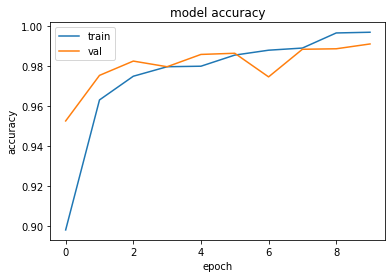

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

In [ ]:
source = "/content/accuracy.png"
destination = "/content/drive/MyDrive/5554/accuracy.png"
sh.copyfile(source, destination)

'/content/drive/MyDrive/5554/accuracy.png'

In [ ]:
# storing history value
with open('HistoryDict.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
source = "/content/HistoryDict.pickle"
destination = "/content/drive/MyDrive/5554/HistoryDict.pickle"
sh.copyfile(source, destination)

'/content/drive/MyDrive/5554/HistoryDict.pickle'

## Getting predictions

In [3]:
weights_path = "/content/drive/MyDrive/5554/binary/models/cnn_epochs:05_acc:0.9857.h5"
pred_model = load_model(weights_path)

In [4]:
pred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

In [5]:
def random_prediction(leaf_type):
  path = "/content/curated_dataset_cnn/" + leaf_type + "/"
  img_name = random.choice(os.listdir(path))
  img_path = path + img_name
  img = cv2.imread(img_path)
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.title(img_name)
  plt.imshow(rgb_img)
  plt.show()

  img_array = rgb_img / 255
  img_array = img_array.reshape(1, 256, 256, 3)
  #print(img_array.shape)
  #print(img_array)
  if pred_model.predict(img_array)[0][0] == 1:
    prediction = "diseased"
  else:
    prediction = "healthy"
  print("Prediction : {}".format(prediction))

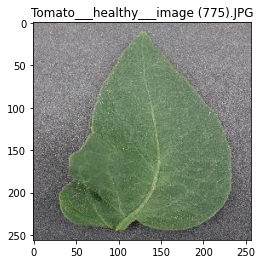

1/1 [==============================] - 9s 9s/step
Prediction : healthy


In [21]:
random_prediction(leaf_type="healthy")

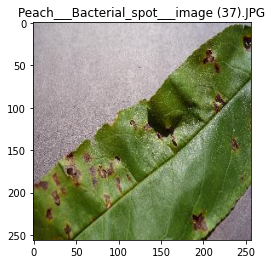

1/1 [==============================] - 0s 15ms/step
Prediction : diseased


In [23]:
random_prediction(leaf_type="diseased")